<a href="https://colab.research.google.com/github/pravin-pandey/brainwaves/blob/master/svm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

sw = pd.read_excel("sleep_work_dataset.xlsx")

sw = sw.reindex(np.random.permutation(sw.index))

In [0]:
def preprocess_features(sw):

  selected_features = sw[
    ["avg_wrk_hrs_per_day",
     "sleep_after_work",
     "mentally_stressed",
     "eeg_signal_in_Hz"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["mental_issue"] = (
    sw["mentally_stressed"] *
    sw["eeg_signal_in_Hz"])
  return processed_features  

def preprocess_targets(sw):
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["sleep_loss_diagnosed"] = (
    sw["sleep_loss_diagnosed"])
  return output_targets

In [8]:
training_examples = preprocess_features(sw.head(440))
training_targets = preprocess_targets(sw.head(440))

validation_examples = preprocess_features(sw.tail(110))
validation_targets = preprocess_targets(sw.tail(110))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,avg_wrk_hrs_per_day,sleep_after_work,mentally_stressed,eeg_signal_in_Hz,mental_issue
count,440.0,440.0,440.0,440.0,440.0
mean,7.7,0.5,0.5,8.1,3.9
std,1.9,0.5,0.5,2.5,4.4
min,1.0,0.0,0.0,4.3,0.0
25%,8.0,0.0,0.0,6.2,0.0
50%,8.0,1.0,0.0,7.8,0.0
75%,8.0,1.0,1.0,9.5,7.8
max,13.0,1.0,1.0,13.6,13.6


Validation examples summary:


,avg_wrk_hrs_per_day,sleep_after_work,mentally_stressed,eeg_signal_in_Hz,mental_issue
count,110.0,110.0,110.0,110.0,110.0
mean,8.3,0.5,0.5,8.5,4.5
std,7.0,0.5,0.5,2.5,4.6
min,1.0,0.0,0.0,4.3,0.0
25%,8.0,0.0,0.0,6.5,0.0
50%,8.0,1.0,1.0,7.8,5.2
75%,8.0,1.0,1.0,9.8,7.8
max,77.0,1.0,1.0,13.6,13.6


Training targets summary:


,sleep_loss_diagnosed
count,440.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,sleep_loss_diagnosed
count,110.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

  periods = 10
  steps_per_period = steps / periods

  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["sleep_loss_diagnosed"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["sleep_loss_diagnosed"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["sleep_loss_diagnosed"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
   
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 5.90
  period 01 : 3.04
  period 02 : 3.00
  period 03 : 2.73
  period 04 : 2.01
  period 05 : 2.48
  period 06 : 1.86
  period 07 : 1.78
  period 08 : 1.31
  period 09 : 1.77
Model training finished.


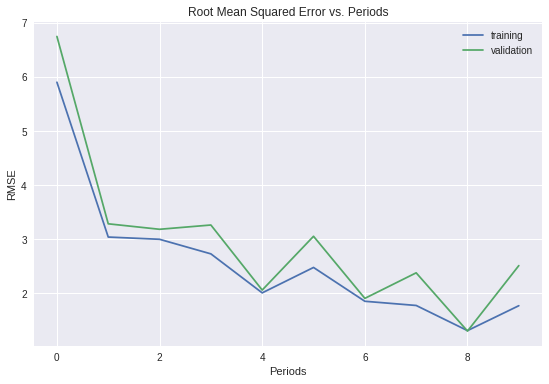

In [12]:
_ = train_model(
    learning_rate=1.0,
    steps=50,
    batch_size=5,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
%matplotlib inline

In [14]:
sw.shape 

(550, 6)

In [15]:
sw = sw.drop(columns="mentally_stressed")
sw.head()  

,ID,avg_wrk_hrs_per_day,sleep_after_work,sleep_loss_diagnosed,eeg_signal_in_Hz
354,355,8.0,1,1,5.6
493,494,8.0,1,1,5.1
227,228,8.0,0,0,5.6
123,124,9.5,0,0,8.9
168,169,8.0,0,1,4.3


In [0]:
X = sw.drop('sleep_loss_diagnosed', axis=1)  
y = sw['sleep_loss_diagnosed'] 

In [0]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [18]:
#linear kernel
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svclassifier.predict(X_test) 

In [20]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

[[56  0]
 [54  0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        56
           1       0.00      0.00      0.00        54

   micro avg       0.51      0.51      0.51       110
   macro avg       0.25      0.50      0.34       110
weighted avg       0.26      0.51      0.34       110



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
#Gaussian kernel
from sklearn.svm import SVC  
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svclassifier.predict(X_test) 

In [23]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[50  6]
 [41 13]]
              precision    recall  f1-score   support

           0       0.55      0.89      0.68        56
           1       0.68      0.24      0.36        54

   micro avg       0.57      0.57      0.57       110
   macro avg       0.62      0.57      0.52       110
weighted avg       0.62      0.57      0.52       110



In [24]:
#Sigmoid kernel
from sklearn.svm import SVC  
svclassifier = SVC(kernel='sigmoid')  
svclassifier.fit(X_train, y_train)  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svclassifier.predict(X_test) 

In [26]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

[[56  0]
 [54  0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        56
           1       0.00      0.00      0.00        54

   micro avg       0.51      0.51      0.51       110
   macro avg       0.25      0.50      0.34       110
weighted avg       0.26      0.51      0.34       110



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
